In [5]:
import numpy as np
import matplotlib.pyplot as plt
# from zhinst.toolkit import Session
from zhinst.qcodes import ZISession

In [6]:
# 接続情報を設定
device_id = "DEV5149"  # 実際のデバイスIDに置き換えてください
server_host = "169.254.254.194"  # 実際のサーバーホストに置き換えてください

# セッションを作成してデバイスに接続
session = ZISession(server_host)
device = session.connect_device(device_id)

General configuration

Selecting the signal paths for recording

In [7]:
# 測定に使用する信号パスを選択
device.demods[0].enable(True)

sample_nodes = [
    device.demods[0].sample.zi_node.lower() + ".x",
    device.demods[0].sample.zi_node.lower() + ".y"
]

Create and configure the Data Acquisition module

General parameters

In [8]:

# データ取得モジュールの作成と設定
TOTAL_DURATION = 10  # 秒
SAMPLING_RATE = 30  # サンプル/秒
BURST_DURATION = 5  # 秒

num_cols = int(np.ceil(SAMPLING_RATE * BURST_DURATION))
num_bursts = int(np.ceil(TOTAL_DURATION / BURST_DURATION))


Module creation

In [9]:

daq_module = session.modules.daq
daq_module.device(device)
daq_module.type(0)  # 継続的な取得
daq_module.grid.mode(2)
daq_module.count(1)
daq_module.duration(BURST_DURATION)
daq_module.preview(True)
daq_module.save.directory('C:\\Users\\qipe\\annealing\\data')
daq_module.grid.cols(num_cols)
daq_module.level(0.00000100)
daq_module.endless(0)


Configuring the data saving settings

In [10]:
# データ保存設定
daq_module.save.fileformat(3)
daq_module.save.filename('zi_toolkit_acq_example')
daq_module.save.saveonread(1)

Subscribing to the nodes

In [11]:
# ノードにサブスクライブ
for node in sample_nodes:
    daq_module.subscribe(node)

clockbase = device.clockbase()

# データ取得とプロットのヘルパー関数
def read_and_plot_data(daq_module, results, ts0):
    daq_data = daq_module.read(raw=False, clk_rate=clockbase)
    progress = daq_module.raw_module.progress()[0]
    for node in sample_nodes:
        # ノードデータが利用可能かチェック
        if node in daq_data.keys():
            print(node)
            for sig_burst in daq_data[node]:
                print(sig_burst[2])
                results[node].append(sig_burst)
                if np.any(np.isnan(ts0)):
                    ts0 = sig_burst.header['createdtimestamp'][0] / clockbase
                t0_burst = sig_burst.header['createdtimestamp'][0] / clockbase
                t = (sig_burst.time + t0_burst) - ts0
                value = sig_burst.value[0, :]
                # データのプロット
                ax1.plot(t, value)
                ax1.set_title(f"Progress of data acquisition: {100 * progress:.2f}%")
                fig.canvas.draw()
                plt.pause(0.001)
    return results, ts0

Recording and plotting the data

/dev5149/demods/0/sample.x
[0.00000000e+00 3.22560000e-02 6.57066667e-02 9.91573333e-02
 1.32608000e-01 1.65461333e-01 1.98912000e-01 2.32362667e-01
 2.65813333e-01 2.99264000e-01 3.32117333e-01 3.65568000e-01
 3.99018667e-01 4.40234667e-01 4.65920000e-01 4.99370667e-01
 5.32224000e-01 5.65674667e-01 5.99125333e-01 6.40938667e-01
 6.66026667e-01 6.98880000e-01 7.32330667e-01 7.65781333e-01
 7.99232000e-01 8.32682667e-01 8.65536000e-01 8.98986667e-01
 9.32437333e-01 9.65888000e-01 9.99338667e-01 1.03219200e+00
 1.06564267e+00 1.09909333e+00 1.14389333e+00 1.16599467e+00
 1.19884800e+00 1.23229867e+00 1.26574933e+00 1.29920000e+00
 1.34340267e+00 1.36550400e+00 1.39895467e+00 1.43240533e+00
 1.46585600e+00 1.49930667e+00 1.54649600e+00 1.56561067e+00
 1.59906133e+00 1.63251200e+00 1.66596267e+00 1.69881600e+00
 1.74720000e+00 1.76571733e+00 1.79916800e+00 1.83261867e+00
 1.86547200e+00 1.89892267e+00 1.93237333e+00 1.96582400e+00
 1.99927467e+00 2.03212800e+00 2.06557867e+00 2.09902933e+

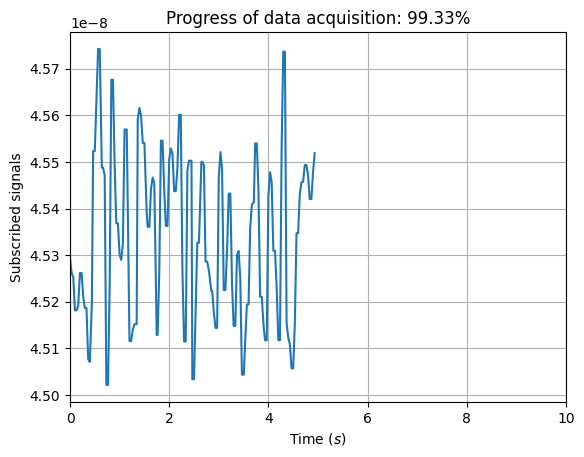

/dev5149/demods/0/sample.y
[0.00000000e+00 3.22560000e-02 6.57066667e-02 9.91573333e-02
 1.32608000e-01 1.65461333e-01 1.98912000e-01 2.32362667e-01
 2.65813333e-01 2.99264000e-01 3.32117333e-01 3.65568000e-01
 3.99018667e-01 4.40234667e-01 4.65920000e-01 4.99370667e-01
 5.32224000e-01 5.65674667e-01 5.99125333e-01 6.40938667e-01
 6.66026667e-01 6.98880000e-01 7.32330667e-01 7.65781333e-01
 7.99232000e-01 8.32682667e-01 8.65536000e-01 8.98986667e-01
 9.32437333e-01 9.65888000e-01 9.99338667e-01 1.03219200e+00
 1.06564267e+00 1.09909333e+00 1.14389333e+00 1.16599467e+00
 1.19884800e+00 1.23229867e+00 1.26574933e+00 1.29920000e+00
 1.34340267e+00 1.36550400e+00 1.39895467e+00 1.43240533e+00
 1.46585600e+00 1.49930667e+00 1.54649600e+00 1.56561067e+00
 1.59906133e+00 1.63251200e+00 1.66596267e+00 1.69881600e+00
 1.74720000e+00 1.76571733e+00 1.79916800e+00 1.83261867e+00
 1.86547200e+00 1.89892267e+00 1.93237333e+00 1.96582400e+00
 1.99927467e+00 2.03212800e+00 2.06557867e+00 2.09902933e+

In [12]:
import time

ts0 = np.nan
timeout = 2 * TOTAL_DURATION
start_time = time.time()
results = {x: [] for x in sample_nodes}

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Time ($s$)")
ax1.set_ylabel("Subscribed signals")
ax1.set_xlim([0, TOTAL_DURATION])
ax1.grid()

# Start recording data
daq_module.execute()

OUT_CHANNEL = 0

device.sigouts[OUT_CHANNEL].on(True)
while time.time() - start_time < timeout:
    results, ts0 = read_and_plot_data(daq_module, results, ts0)
    if daq_module.raw_module.finished():
        # Once finished, call once more to get the potential remaining data.
        results, ts0 = read_and_plot_data(daq_module, results, ts0)
        break
    time.sleep(BURST_DURATION)
device.sigouts[OUT_CHANNEL].on(False)

In [13]:
for node in sample_nodes:
    print(node)
    if node in results.keys():
            for sig_burst in results[node]:
                print(sig_burst)

/dev5149/demods/0/sample.x
DAQResult(header={'systemtime': array([1717997328], dtype=uint64), 'createdtimestamp': array([56169374097186], dtype=uint64), 'changedtimestamp': array([56169673617026], dtype=uint64), 'flags': array([4408], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '000 14:28:48.4678', 'status': array([0], dtype=uint32), 'groupindex': array([0], dtype=uint32), 'color': array([0], dtype=uint32), 'activerow': array([0], dtype=uint32), 'triggernumber': array([0], dtype=uint64), 'gridrows': array([1], dtype=uint32), 'gridcols': array([150], dtype=uint32), 'gridmode': array([2], dtype=uint32), 'gridoperation': array([1], dtype=uint32), 'griddirection': array([0], dtype=uint32), 'gridrepetitions': array([1], dtype=uint32), 'gridcoldelta': array([0.03333332]), 'gridcoloffset': array([-0.001]), 'gridrowdelta': array([1.]), 'gridrowoffset': array([0.]), 'bandwidth': array([nan]), 'center': array([0.]), 'nenbw': array([

#Live Plot

In [14]:
import time
import os
import qcodes as qc

import numpy as np
from plottr.data.datadict_storage import DataDict, DDH5Writer

In [15]:
data_path = 'C:\\Users\\qipe\\annealing\\data'
timestr = time.strftime("%Y%m%d-%H%M%S")
measurement_name = timestr

In [16]:
data_dict = DataDict(
    time = dict(unit ='s'),
    amp = dict(unit = 'V', axes = ["time"])
)
data_dict.validate

<bound method DataDict.validate of amp (V): (0,)
  ⌙ time (s): (0,)>

In [4]:
sample_node = device.demods[0].sample.zi_node.lower() + ".r"

NameError: name 'device' is not defined

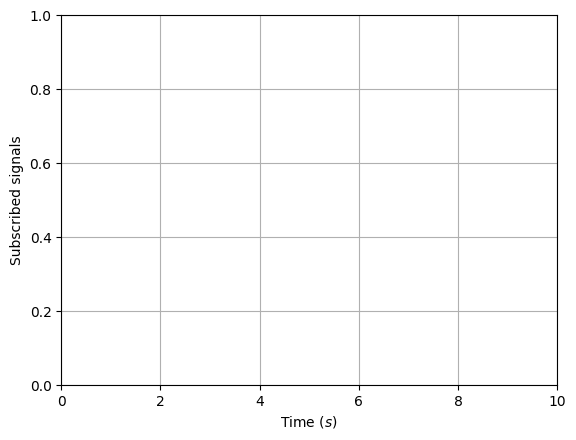

In [14]:
# ノードにサブスクライブ

daq_module.subscribe(sample_node)

clockbase = device.clockbase()

import time

ts0 = np.nan
timeout = 2 * TOTAL_DURATION
start_time = time.time()
results = {x: [] for x in sample_node}

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Time ($s$)")
ax1.set_ylabel("Subscribed signals")
ax1.set_xlim([0, TOTAL_DURATION])
ax1.grid()

# Start recording data
daq_module.execute()

OUT_CHANNEL = 0

device.sigouts[OUT_CHANNEL].on(True)

def daq_measure(daq_module):
    device.sigouts[OUT_CHANNEL].on(True)
    daq_module.execute()
    progress = daq_module.raw_module.progress()[0]
    try:
        while progress < 1.0:
            print(f"progress {progress*100}%")
            progress = daq_module.raw_module.progress()[0]
            daq_data = daq_module.read(raw=False, clk_rate=clockbase)
        # for node in sample_node:
            # ノードデータが利用可能かチェック
            # if sample_node in daq_data.keys():
            #     print(sample_node)
            #     for sig_burst in daq_data[sample_node]:
            #         print(sig_burst[2])
            #         # results[sample_node].append(sig_burst)
            #         if np.any(np.isnan(ts0)):
            #             ts0 = sig_burst.header['createdtimestamp'][0] / clockbase
            #         t0_burst = sig_burst.header['createdtimestamp'][0] / clockbase
            #         t = (sig_burst.time + t0_burst) - ts0
            #         value = sig_burst.value[0, :]
            #         # # データのプロット
            #         # ax1.plot(t, value)
            #         # ax1.set_title(f"Progress of data acquisition: {100 * progress:.2f}%")
            #         # fig.canvas.draw()
            #         # plt.pause(0.001)

            time.sleep(BURST_DURATION)
            
    finally:
        daq_data = daq_module.read(raw=False, clk_rate=clockbase)
        amp = daq_data[sample_node][1]
        timer = daq_data[sample_node][2]
        device.sigouts[OUT_CHANNEL].on(False)
        for node in sample_node:
            daq_module.unsubscribe(node)
        return daq_data, amp, timer
        
    # for node in sample_node:
    #     # ノードデータが利用可能かチェック
    #     if node in daq_data.keys():
    #         for sig_burst in daq_data[node]:
    #             results[node].append(sig_burst)
    #             if np.any(np.isnan(ts0)):
    #                 ts0 = sig_burst.header['createdtimestamp'][0] / clockbase
    #             t0_burst = sig_burst.header['createdtimestamp'][0] / clockbase
    #             t = (sig_burst.time + t0_burst) - ts0
    #             value = sig_burst.value[0, :]
    # device.sigouts[OUT_CHANNEL].on(False)
    # return daq_data, t

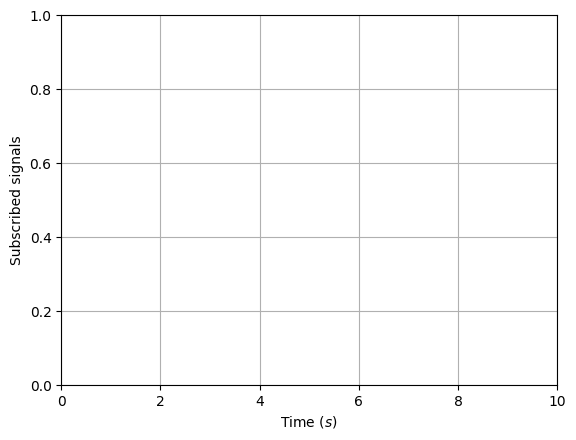

In [16]:
# ノードにサブスクライブ

daq_module.subscribe(sample_node)

clockbase = device.clockbase()

import time

ts0 = np.nan
timeout = 2 * TOTAL_DURATION
start_time = time.time()
results = {x: [] for x in sample_node}

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Time ($s$)")
ax1.set_ylabel("Subscribed signals")
ax1.set_xlim([0, TOTAL_DURATION])
ax1.grid()

# Start recording data
daq_module.execute()

OUT_CHANNEL = 0

device.sigouts[OUT_CHANNEL].on(True)

daq_module.execute()
daq_data = daq_module.read(raw=False, clk_rate=clockbase)
progress = daq_module.raw_module.progress()[0]
time.sleep(1.7*TOTAL_DURATION)
daq_data = daq_module.read(raw=False, clk_rate=clockbase)

device.sigouts[OUT_CHANNEL].on(False)

In [17]:
daq_data[sample_node][0][1]

array([[0.00140812, 0.00140608, 0.0014055 , 0.00140643, 0.00140813,
        0.00140547, 0.00140464, 0.00140603, 0.00140717, 0.00140464,
        0.00140538, 0.0014071 , 0.00140599, 0.00140766, 0.00140626,
        0.00140619, 0.00140661, 0.00140609, 0.00140634, 0.00140579,
        0.00140834, 0.00140747, 0.00140866, 0.00140339, 0.0014063 ,
        0.00140608, 0.00140797, 0.00140631, 0.00140764, 0.00140785,
        0.00140826, 0.00140763, 0.00140648, 0.00140845, 0.00140694,
        0.00140633, 0.0014078 , 0.00140822, 0.0014085 , 0.00140785,
        0.00140713, 0.00140656, 0.00140342, 0.00140733, 0.00140857,
        0.00140726, 0.0014078 , 0.00140693, 0.00140625, 0.00140651,
        0.00140612, 0.0014084 , 0.0014049 , 0.00140721, 0.00140729,
        0.00140773, 0.0014047 , 0.00140553, 0.00140538, 0.00140862,
        0.0014059 , 0.00140482, 0.00140629, 0.0014078 , 0.00140738,
        0.0014067 , 0.0014083 , 0.00141259, 0.00140643, 0.00140535,
        0.00140476, 0.00140463, 0.00140441, 0.00

In [18]:
with DDH5Writer(data_dict, data_path, name = measurement_name) as writer:
    writer.add_data(
        time = daq_data[sample_node][0][2],
        amp = daq_data[sample_node][0][1],
    )

In [ ]:
# def freq_sweep():
#     MFLI_lockin.sigouts[OUT_CHANNEL].on(True)
#     sweeper.save.saveonread(True)
#     sweeper.execute()
#     print(f"Perform {LOOPCOUNT} sweeps")
#     try:
#         while sweeper.progress() < 1.0:
#             print(f"progress {sweeper.progress()*100}%")
#             data = sweeper.read()
#             time.sleep(0.1)
#     finally:
#         data = sweeper.read()
#         MFLI_lockin.sigouts[OUT_CHANNEL].on(False)
#         sweeper.unsubscribe(sample_node)
#         return data
#         # sweeper.save.save(True)
#         # # Wait until the save is complete. The saving is done asynchronously in the background
#         # # so we need to wait until it is complete. In the case of the sweeper it is important
#         # # to wait for completion before before performing the module read command. The sweeper has
#         # # a special fast read command which could otherwise be executed before the saving has
#         # # started.
#         # sweeper.save.save.wait_for_state_change(True, invert=True, timeout=5)
 

Saving the data

In [19]:
# daq_module.save.save.wait_for_state_change(0, timeout=10)

??

In [12]:
daq_module.set('endless', 1)
daq_module.subscribe('/dev5149/demods/0/sample.R')
daq_module.execute()
# To read the acquired data from the module, use a
# while loop like the one below. This will allow the
# data to be plotted while the measurement is ongoing.
# Note that any device nodes that enable the streaming
# of data to be acquired, must be set before the while loop.
# result = 0
# while daq_module.progress() < 1.0 and not daq_module.finished():
#     time.sleep(1)
#     result = daq_module.read()
#     print(f"Progress {float(daq_module.progress()) * 100:.2f} %\r")
daq_module.finish()
daq_module.unsubscribe('*')